In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.optimize import lsq_linear

In [ ]:
m = np.random.rand(20,10)
n = np.random.rand(10)
bounds_list = [(0,np.inf) for _ in range(10)]
bounds_list[8] = (-0.4,0)
res = lsq_linear(m, n,bounds=bounds_list, lsmr_tol= 1e-15)
res

(0.0, 3.0, 0.0, 3.0)

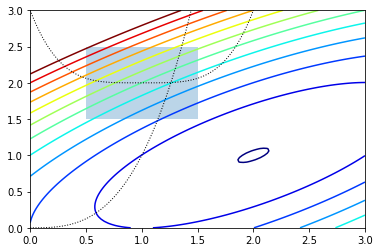

In [2]:
def f(x):
    return -(2*x[0]*x[1] + 2*x[0] - x[0]**2 - 2*x[1]**2)


x = np.linspace(0, 3, 100)
y = np.linspace(0, 3, 100)
X, Y = np.meshgrid(x, y)
Z = f(np.vstack([X.ravel(), Y.ravel()])).reshape((100,100))
plt.contour(X, Y, Z, np.arange(-1.99,10, 1), cmap='jet');
plt.plot(x, x**3, 'k:', linewidth=1)
plt.plot(x, (x-1)**4+2, 'k:', linewidth=1)
plt.fill([0.5,0.5,1.5,1.5], [2.5,1.5,1.5,2.5], alpha=0.3)
plt.axis([0,3,0,3])

In [3]:
import numpy as np
import statsmodels.api as sm
from gekko import GEKKO

# Data
x0 = np.array([4,5,2,3,-1,1,6,7])
x1 = np.array([3,2,3,4, 3,5,2,6])
y = np.array([0.3,0.8,-0.05,0.1,-0.8,-0.5,0.5,0.65])

# calculate R^2
def rsq(y1,y2):
    yresid= y1 - y2
    SSresid = np.sum(yresid**2)
    SStotal = len(y1) * np.var(y1)
    r2 = 1 - SSresid/SStotal
    return r2

# Method 1: numpy linalg solution
#       Y =     X a
#   X^T Y = X^T X a
X = np.vstack((x0,x1,np.ones(len(x0)))).T
a = np.linalg.lstsq(X,y)[0]; print(a)
yfit = a[0]*x0+a[1]*x1+a[2]
print('R^2 = '+str(rsq(y,yfit)))

# Method 2: statsmodels ordinary least squares
model = sm.OLS(y,X).fit()
predictions = model.predict(X)
print(model.summary())

# Method 3: gekko
m = GEKKO(remote=False); m.options.IMODE=2
c  = m.Array(m.FV,3)
for ci in c:
    ci.STATUS=1
xd = m.Array(m.Param,2); xd[0].value=x0; xd[1].value=x1
yd = m.Param(y); yp = m.Var()
s =  m.sum([c[i]*xd[i] for i in range(2)])
m.Equation(yp==s+c[-1])
m.Minimize((yd-yp)**2)
m.solve(disp=False)
a = [c[i].value[0] for i in range(3)]
print(a)

import matplotlib.pyplot as plt
from matplotlib import cm
# plot data
from mpl_toolkits import mplot3d

fig = plt.figure()
ax  = plt.axes(projection='3d')
ax.plot3D(x0,x1,y,'ko')
x0t = np.arange(-1,7,0.25)
x1t = np.arange(2,6,0.25)
X0,X1 = np.meshgrid(x0t,x1t)
Yt = a[0]*X0+a[1]*X1+a[2]
ax.plot_surface(X0,X1,Yt,cmap=cm.coolwarm,alpha=0.5)
plt.show()

ModuleNotFoundError: No module named 'gekko'

In [ ]:
import numpy as np
from sklearn.base import RegressorMixin
from sklearn.linear_model import LinearRegression
from sklearn.utils import check_X_y


class ConstrainedLinearRegression(LinearRegression, RegressorMixin):

    def __init__(self, fit_intercept=True, normalize=False, copy_X=True, nonnegative=False, tol=1e-15):
        self.fit_intercept = fit_intercept
        self.normalize = normalize
        self.copy_X = copy_X
        self.nonnegative = nonnegative
        self.tol = tol

    def fit(self, X, y, min_coef=None, max_coef=None):
        X, y = check_X_y(X, y, accept_sparse=['csr', 'csc', 'coo'], y_numeric=True, multi_output=False)
        X, y, X_offset, y_offset, X_scale = self._preprocess_data(
            X, y, fit_intercept=self.fit_intercept, normalize=self.normalize, copy=self.copy_X)
        self.min_coef_ = min_coef if min_coef is not None else np.repeat(-np.inf, X.shape[1])
        self.max_coef_ = max_coef if max_coef is not None else np.repeat(np.inf, X.shape[1])
        if self.nonnegative:
            self.min_coef_ = np.clip(self.min_coef_, 0, None)

        beta = np.zeros(X.shape[1]).astype(float)
        prev_beta = beta + 1
        hessian = np.dot(X.transpose(), X)
        while not (np.abs(prev_beta - beta)<self.tol).all():
            prev_beta = beta.copy()
            for i in range(len(beta)):
                grad = np.dot(np.dot(X,beta) - y, X)
                beta[i] = np.minimum(self.max_coef_[i], 
                                     np.maximum(self.min_coef_[i], 
                                                beta[i]-grad[i] / hessian[i,i]))

        self.coef_ = beta
        self._set_intercept(X_offset, y_offset, X_scale)
        return self  

In [ ]:
from sklearn.datasets import load_boston
from sklearn.linear_model import LinearRegression

X, y = load_boston(return_X_y=True)
model = ConstrainedLinearRegression(nonnegative=True)
model.fit(X, y)
print(model.intercept_)
print(model.coef_)

-36.99292986145538
[0.         0.05286515 0.         4.12512386 0.         8.04017956
 0.         0.         0.         0.         0.         0.02273805
 0.        ]


/home/alias/miniconda3/envs/py3.7/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function load_boston is deprecated; `load_boston` is deprecated in 1.0 and will be removed in 1.2.

    The Boston housing prices dataset has an ethical problem. You can refer to
    the documentation of this function for further details.

    The scikit-learn maintainers therefore strongly discourage the use of this
    dataset unless the purpose of the code is to study and educate about
    ethical issues in data science and machine learning.

    In this special case, you can fetch the dataset from the original
    source::

        import pandas as pd
        import numpy as np


        data_url = "http://lib.stat.cmu.edu/datasets/boston"
        raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
        data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
        target = raw_df.values[1::2, 2]

    Alternative datasets include the Californi

In [ ]:
X.shape

(506, 13)

In [ ]:
y.shape

(506,)

In [ ]:
model = LinearRegression()
model.fit(X, y)
print(model.intercept_)
print(model.coef_)

36.45948838509001
[-1.08011358e-01  4.64204584e-02  2.05586264e-02  2.68673382e+00
 -1.77666112e+01  3.80986521e+00  6.92224640e-04 -1.47556685e+00
  3.06049479e-01 -1.23345939e-02 -9.52747232e-01  9.31168327e-03
 -5.24758378e-01]


In [ ]:
model = ConstrainedLinearRegression()
min_coef = np.repeat(-np.inf, X.shape[1])
min_coef[0] = 0
min_coef[4] = -1
max_coef = np.repeat(4, X.shape[1])
max_coef[3] = 2


In [ ]:
min_coef

array([  0., -inf, -inf, -inf,  -1., -inf, -inf, -inf, -inf, -inf, -inf,
       -inf, -inf])

In [ ]:
max_coef

array([4, 4, 4, 2, 4, 4, 4, 4, 4, 4, 4, 4, 4])

In [ ]:
model.fit(X, y, max_coef=max_coef, min_coef=min_coef)
print(model.intercept_)
print(model.coef_)

24.06017557641051
[ 0.          0.04504673 -0.0354073   2.         -1.          4.
 -0.01343263 -1.17231216  0.2183103  -0.01375266 -0.7747823   0.01122374
 -0.56678676]


In [ ]:
new_X = np.random.rand(20,10)
new_X.shape

(20, 10)

In [ ]:
y = np.random.rand(20)
y

array([0.56030589, 0.27956457, 0.79309773, 0.16931961, 0.19474253,
       0.06747238, 0.66849674, 0.58246435, 0.51793367, 0.07994603,
       0.98148131, 0.75391525, 0.82884543, 0.12644207, 0.19893911,
       0.57155196, 0.95261829, 0.93567092, 0.92832986, 0.79979654])

In [ ]:
model = ConstrainedLinearRegression(fit_intercept=False)
min_coef = np.repeat(-0.4, new_X.shape[1])
min_coef[0:8] = 0
min_coef[9] = 0
max_coef = np.repeat(np.inf, new_X.shape[1])
max_coef[8] = 0
print(min_coef, max_coef)

[ 0.   0.   0.   0.   0.   0.   0.   0.  -0.4  0. ] [inf inf inf inf inf inf inf inf  0. inf]


In [ ]:
model.fit(new_X, y, max_coef=max_coef, min_coef=min_coef)
print(model.intercept_)
print(model.coef_)

0.0
[ 0.          0.          0.66592036  0.          0.22717361  0.
  0.          0.         -0.00371818  0.31811331]


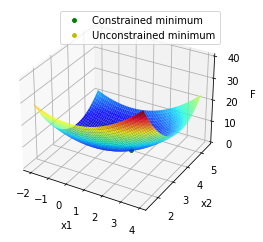

In [ ]:
import numpy as np
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d.axes3d import Axes3D
from scipy import optimize

# minimize
#     F = x[1]^2 + 4x[2]^2 -32x[2] + 64

# subject to:
#      x[1] + x[2] <= 7
#     -x[1] + 2x[2] <= 4
#      x[1] >= 0
#      x[2] >= 0
#      x[2] <= 4

# in matrix notation:
#     F = (1/2)*x.T*H*x + c*x + c0

# subject to:
#     Ax <= b

# where:
#     H = [[2, 0],
#          [0, 8]]

#     c = [0, -32]

#     c0 = 64

#     A = [[ 1, 1],
#          [-1, 2],
#          [-1, 0],
#          [0, -1],
#          [0,  1]]

#     b = [7,4,0,0,4]

H = np.array([[2., 0.],
              [0., 8.]])

c = np.array([0, -32])

c0 = 64

A = np.array([[ 1., 1.],
              [-1., 2.],
              [-1., 0.],
              [0., -1.],
              [0.,  1.]])

b = np.array([7., 4., 0., 0., 4.])

x0 = np.random.randn(2)

def loss(x, sign=1.):
    return sign * (0.5 * np.dot(x.T, np.dot(H, x))+ np.dot(c, x) + c0)

def jac(x, sign=1.):
    return sign * (np.dot(x.T, H) + c)

cons = {'type':'ineq',
        'fun':lambda x: b - np.dot(A,x),
        'jac':lambda x: -A}

opt = {'disp':False}

def solve():

    res_cons = optimize.minimize(loss, x0, jac=jac,constraints=cons,
                                 method='SLSQP', options=opt)

    res_uncons = optimize.minimize(loss, x0, jac=jac, method='SLSQP',
                                   options=opt)


    x1, x2 = res_cons['x']
    f = res_cons['fun']

    x1_unc, x2_unc = res_uncons['x']
    f_unc = res_uncons['fun']

    # plotting
    xgrid = np.mgrid[-2:4:0.1, 1.5:5.5:0.1]
    xvec = xgrid.reshape(2, -1).T
    F = np.vstack([loss(xi) for xi in xvec]).reshape(xgrid.shape[1:])

    ax = plt.axes(projection='3d')
    #ax.hold(True)
    ax.plot_surface(xgrid[0], xgrid[1], F, rstride=1, cstride=1,
                    cmap=plt.cm.jet, shade=True, alpha=0.9, linewidth=0)
    ax.plot3D([x1], [x2], [f], 'og', mec='w', label='Constrained minimum')
    ax.plot3D([x1_unc], [x2_unc], [f_unc], 'oy', mec='w',
              label='Unconstrained minimum')
    ax.legend(fancybox=True, numpoints=1)
    ax.set_xlabel('x1')
    ax.set_ylabel('x2')
    ax.set_zlabel('F')
    plt.show()
solve()